# Donors Choose Data Analysis

#### Objective - To predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school.

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1. Reading the data

In [3]:
project_data = pd.read_csv('./train_data.csv')
resources_data = pd.read_csv('./resources.csv')

In [4]:
project_data.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

            project_subject_categories     project_subject_subcategories  \
0                  Literacy & Language                     ESL, Literacy   
1    History & Civics, Health & Sports  Civics & Government, Team Sports   
2                      Health & Sports    Health & Wellness, Team Sports   
3  Literacy & Language, Math & Science             Literacy, Mathematics   
4                       Math & Science                       Mathematics   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1  
2                                             1                    0  
3                                             4                    1  
4                                             1                    1

In [5]:
project_data.shape

(109248, 17)

In [6]:
print(project_data.columns.values)

['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [7]:
resources_data.head()

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

In [8]:
resources_data.shape

(1541272, 4)

In [9]:
print(resources_data.columns.values)

['id' 'description' 'quantity' 'price']


## 2. Donors Choose EDA

In [10]:
y_counts = project_data['project_is_approved'].value_counts()
print("No. of projects approved",y_counts[0],",(",(y_counts[0]/(y_counts[0]+y_counts[1]))*100,"%)")
print("No. of projects rejected",y_counts[1],",(",(y_counts[1]/(y_counts[0]+y_counts[1]))*100,"%)")

No. of projects approved 16542 ,( 15.141695957820739 %)
No. of projects rejected 92706 ,( 84.85830404217927 %)


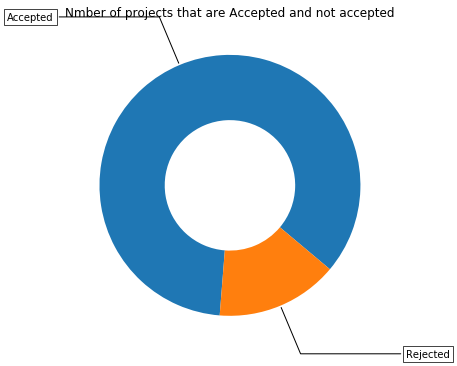

In [11]:
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(aspect='equal'))
recipe = ['Accepted', 'Rejected']

data = [y_counts[1], y_counts[0]]
wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc='w' , ec='k' , lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

# print(kw)
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

### 2.1 Univariate Analysis

In [12]:
#https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [13]:
#https://stackoverflow.com/a/51540521/4084039
#https://stackoverflow.com/a/19385591/4084039

def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

#### 1. School State

In [14]:
temp = pd.DataFrame(project_data.groupby('school_state')['project_is_approved'].apply(np.mean)).reset_index()
temp.columns = ['state_code', 'num_projects_approved']
print(temp)

   state_code  num_projects_approved
0          AK               0.840580
1          AL               0.854711
2          AR               0.831268
3          AZ               0.838379
4          CA               0.858136
5          CO               0.841584
6          CT               0.868912
7          DC               0.802326
8          DE               0.897959
9          FL               0.831690
10         GA               0.840020
11         HI               0.856016
12         IA               0.852853
13         ID               0.835498
14         IL               0.852874
15         IN               0.845038
16         KS               0.839117
17         KY               0.863497
18         LA               0.831245
19         MA               0.860193
20         MD               0.838838
21         ME               0.847525
22         MI               0.845302
23         MN               0.857616
24         MO               0.854814
25         MS               0.845049
2

In [15]:
#https://datascience.stackexchange.com/a/9620

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = temp['state_code'],
        z = temp['num_projects_approved'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')

In [16]:
temp.sort_values(by=['num_projects_approved'], inplace=True)
print("States with highest approval rating")
print(temp.tail(5))
print("States with lowest approval rating")
print(temp.head(5))

States with highest approval rating
   state_code  num_projects_approved
30         NH               0.873563
35         OH               0.875152
47         WA               0.876178
28         ND               0.888112
8          DE               0.897959
States with lowest approval rating
   state_code  num_projects_approved
46         VT               0.800000
7          DC               0.802326
43         TX               0.813142
26         MT               0.816327
18         LA               0.831245


In [17]:
temp1 = pd.DataFrame(project_data.groupby('school_state')['project_is_approved'].agg(lambda x: x.eq(1).sum())).reset_index()
temp1

school_state  project_is_approved
0            AK                  290
1            AL                 1506
2            AR                  872
3            AZ                 1800
4            CA                13205
5            CO                  935
6            CT                 1445
7            DC                  414
8            DE                  308
9            FL                 5144
10           GA                 3329
11           HI                  434
12           IA                  568
13           ID                  579
14           IL                 3710
15           IN                 2214
16           KS                  532
17           KY                 1126
18           LA                 1990
19           MA                 2055
20           MD                 1270
21           ME                  428
22           MI                 2672
23           MN                 1036
24           MO                 2202
25           MS                 1118
26           MT                  200
27           NC                 4353
28           ND                  127
29           NE                  260
30           NH                  304
31           NJ                 1888
32           NM                  479
33           NV                 1167
34           NY                 6291
35           OH                 2159
36           OK                 1900
37           OR                 1056
38           PA                 2658
39           RI                  243
40           SC                 3385
41           SD                  252
42           TN                 1435
43           TX                 6014
44           UT                 1448
45           VA                 1739
46           VT                   64
47           WA                 2045
48           WI                 1545
49           WV                  430
50           WY                   82

In [18]:
temp1['total'] = pd.DataFrame(project_data.groupby('school_state')['project_is_approved'].agg({'total':'count'})).reset_index()['total']
temp1['Avg'] = pd.DataFrame(project_data.groupby('school_state')['project_is_approved'].agg({'Avg':'mean'})).reset_index()['Avg']

In [19]:
temp1

school_state  project_is_approved  total       Avg
0            AK                  290    345  0.840580
1            AL                 1506   1762  0.854711
2            AR                  872   1049  0.831268
3            AZ                 1800   2147  0.838379
4            CA                13205  15388  0.858136
5            CO                  935   1111  0.841584
6            CT                 1445   1663  0.868912
7            DC                  414    516  0.802326
8            DE                  308    343  0.897959
9            FL                 5144   6185  0.831690
10           GA                 3329   3963  0.840020
11           HI                  434    507  0.856016
12           IA                  568    666  0.852853
13           ID                  579    693  0.835498
14           IL                 3710   4350  0.852874
15           IN                 2214   2620  0.845038
16           KS                  532    634  0.839117
17           KY                 1126   1304  0.863497
18           LA                 1990   2394  0.831245
19           MA                 2055   2389  0.860193
20           MD                 1270   1514  0.838838
21           ME                  428    505  0.847525
22           MI                 2672   3161  0.845302
23           MN                 1036   1208  0.857616
24           MO                 2202   2576  0.854814
25           MS                 1118   1323  0.845049
26           MT                  200    245  0.816327
27           NC                 4353   5091  0.855038
28           ND                  127    143  0.888112
29           NE                  260    309  0.841424
30           NH                  304    348  0.873563
31           NJ                 1888   2237  0.843987
32           NM                  479    557  0.859964
33           NV                 1167   1367  0.853694
34           NY                 6291   7318  0.859661
35           OH                 2159   2467  0.875152
36           OK                 1900   2276  0.834798
37           OR                 1056   1242  0.850242
38           PA                 2658   3109  0.854937
39           RI                  243    285  0.852632
40           SC                 3385   3936  0.860010
41           SD                  252    300  0.840000
42           TN                 1435   1688  0.850118
43           TX                 6014   7396  0.813142
44           UT                 1448   1731  0.836511
45           VA                 1739   2045  0.850367
46           VT                   64     80  0.800000
47           WA                 2045   2334  0.876178
48           WI                 1545   1827  0.845649
49           WV                  430    503  0.854871
50           WY                   82     98  0.836735

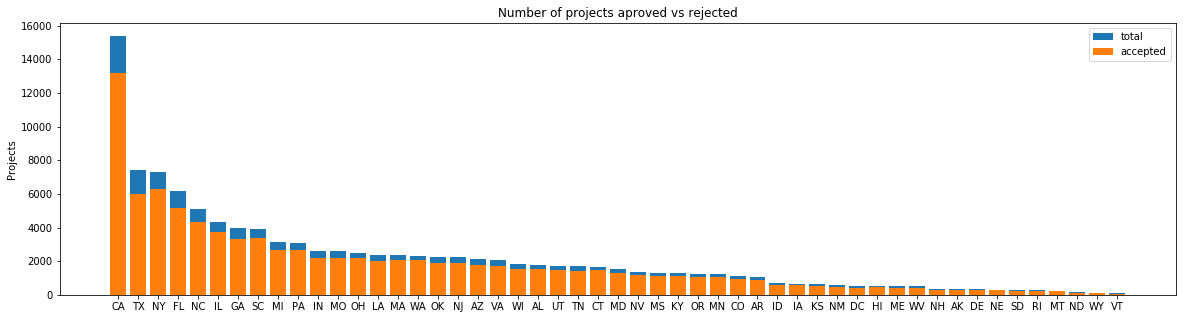

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [20]:
univariate_barplots(temp,'school_state','project_is_approved')

##### Observation: Every state has more than 80% approval rating.

#### 2. Teacher Prefix

In [21]:
temp = pd.DataFrame(project_data.groupby('teacher_prefix')['project_is_approved'].apply(np.mean)).reset_index()
temp

teacher_prefix  project_is_approved
0            Dr.             0.692308
1            Mr.             0.841473
2           Mrs.             0.855559
3            Ms.             0.843537
4        Teacher             0.795339

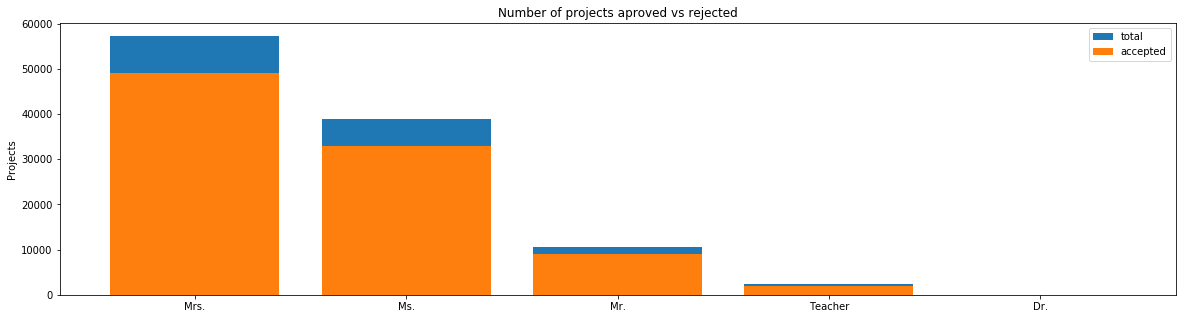

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [22]:
univariate_barplots(temp,'teacher_prefix','project_is_approved')

##### Observation: The highest approval rating is for teachers with 'Mrs.' and 'Ms.' as prefixes in their names, and the prefixes, 'Teacher' and 'Dr.' has the lowest approval rating.

#### 3. Project Grade category

In [23]:
temp = pd.DataFrame(project_data.groupby('project_grade_category')['project_is_approved'].apply(np.mean)).reset_index()
temp

project_grade_category  project_is_approved
0             Grades 3-5             0.854377
1             Grades 6-8             0.842522
2            Grades 9-12             0.837636
3          Grades PreK-2             0.848751

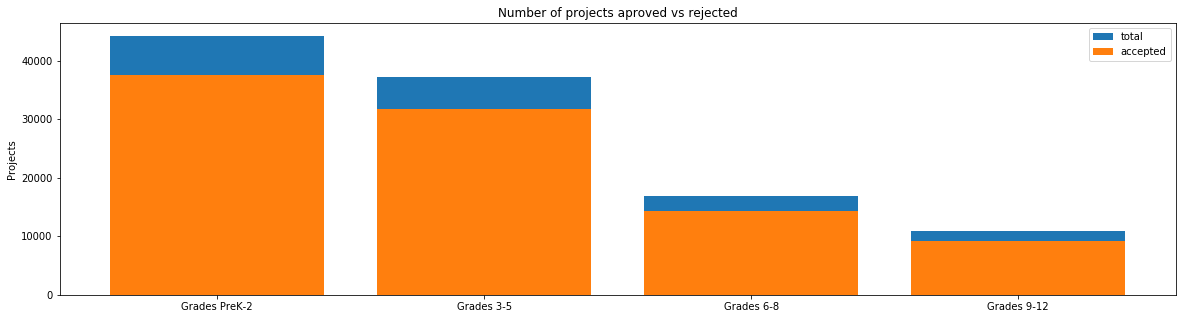

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [24]:
univariate_barplots(temp,'project_grade_category','project_is_approved')

#### 4. Project Subject Categories

In [25]:
list_categories = list(project_data['project_subject_categories'].values)
list_categories

['Literacy & Language',
 'History & Civics, Health & Sports',
 'Health & Sports',
 'Literacy & Language, Math & Science',
 'Math & Science',
 'Literacy & Language, Special Needs',
 'Literacy & Language, Special Needs',
 'Math & Science',
 'Health & Sports',
 'Literacy & Language',
 'Literacy & Language',
 'Literacy & Language, Applied Learning',
 'Math & Science',
 'Special Needs',
 'Literacy & Language',
 'Health & Sports',
 'Literacy & Language, Special Needs',
 'Math & Science, Literacy & Language',
 'Applied Learning',
 'Health & Sports',
 'Literacy & Language',
 'Math & Science, Special Needs',
 'Literacy & Language',
 'Music & The Arts',
 'Math & Science',
 'Math & Science',
 'Literacy & Language, Math & Science',
 'Literacy & Language, Math & Science',
 'Literacy & Language, Special Needs',
 'Literacy & Language, Applied Learning',
 'Literacy & Language',
 'Special Needs',
 'Math & Science, Literacy & Language',
 'History & Civics',
 'Literacy & Language',
 'Health & Sports',
 '

In [26]:
# https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

cat_list = []
for i in list_categories:
    temp = " "
    for j in i.split(','):
        if "The" in j:
            j=j.replace('The', '')
        j=j.replace(' ','')
        temp = temp + j.strip() + " "
        temp = temp.replace('&','_')
    cat_list.append(temp.strip())
cat_list

['Literacy_Language',
 'History_Civics Health_Sports',
 'Health_Sports',
 'Literacy_Language Math_Science',
 'Math_Science',
 'Literacy_Language SpecialNeeds',
 'Literacy_Language SpecialNeeds',
 'Math_Science',
 'Health_Sports',
 'Literacy_Language',
 'Literacy_Language',
 'Literacy_Language AppliedLearning',
 'Math_Science',
 'SpecialNeeds',
 'Literacy_Language',
 'Health_Sports',
 'Literacy_Language SpecialNeeds',
 'Math_Science Literacy_Language',
 'AppliedLearning',
 'Health_Sports',
 'Literacy_Language',
 'Math_Science SpecialNeeds',
 'Literacy_Language',
 'Music_Arts',
 'Math_Science',
 'Math_Science',
 'Literacy_Language Math_Science',
 'Literacy_Language Math_Science',
 'Literacy_Language SpecialNeeds',
 'Literacy_Language AppliedLearning',
 'Literacy_Language',
 'SpecialNeeds',
 'Math_Science Literacy_Language',
 'History_Civics',
 'Literacy_Language',
 'Health_Sports',
 'Literacy_Language Math_Science',
 'Health_Sports Literacy_Language',
 'Health_Sports',
 'Literacy_Languag

In [27]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'],axis=1,inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

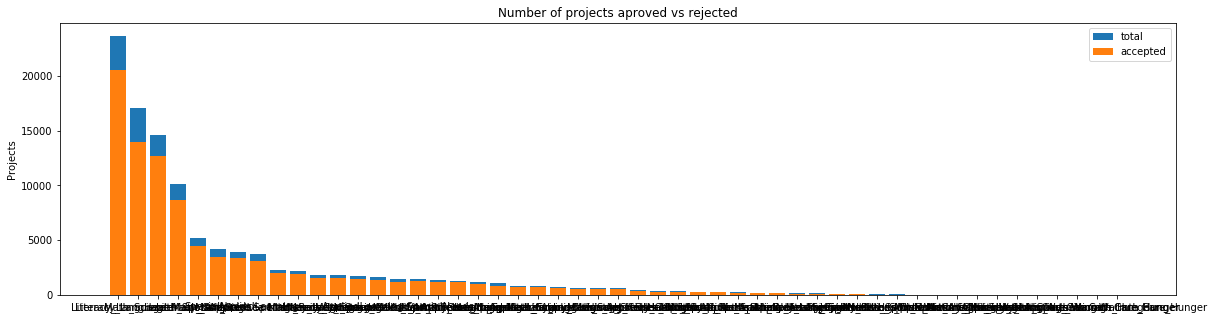

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                        clean_categories  project_is_approved  total       Avg
41            Music_Arts AppliedLearning                    7     10  0.700000
7     AppliedLearning Warmth Care_Hunger                    8     10  0.800000
31  Literacy_Language Warmth Care_Hunger                    7      9  0.777778
45         Music_Arts Warmth Care_Hunger                    1      2  0.500000
23     History_Civics Warmth Care_Hunger                    0      1  0.000000


In [28]:
temp = pd.DataFrame(project_data.groupby('clean_categories')['project_is_approved'].apply(np.mean)).reset_index()
univariate_barplots(temp,'clean_categories', 'project_is_approved')

In [29]:
# https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

In [30]:
cat_dict = dict(my_counter)
cat_dict

{'Literacy_Language': 52239,
 'History_Civics': 5914,
 'Health_Sports': 14223,
 'Math_Science': 41421,
 'SpecialNeeds': 13642,
 'AppliedLearning': 12135,
 'Music_Arts': 10293,
 'Warmth': 1388,
 'Care_Hunger': 1388}

In [31]:
# https://stackoverflow.com/a/613218/4084039
sorted_cat_dict = dict(sorted(cat_dict.items(), key = lambda kv: kv[1]))
sorted_cat_dict

{'Warmth': 1388,
 'Care_Hunger': 1388,
 'History_Civics': 5914,
 'Music_Arts': 10293,
 'AppliedLearning': 12135,
 'SpecialNeeds': 13642,
 'Health_Sports': 14223,
 'Math_Science': 41421,
 'Literacy_Language': 52239}

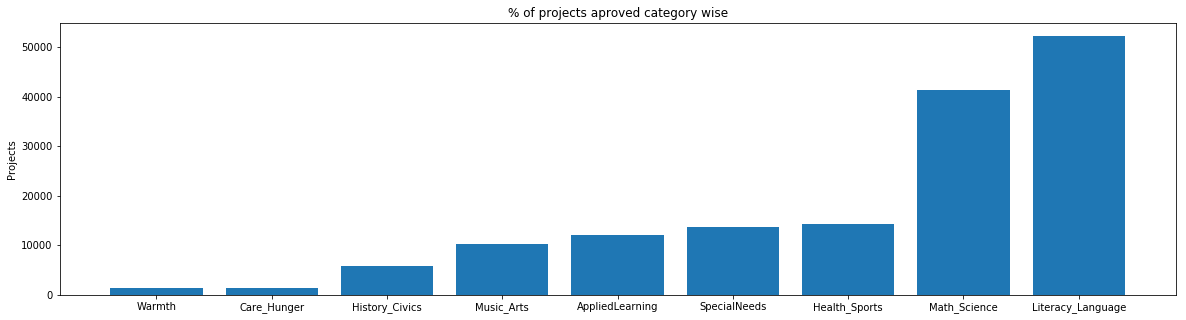

In [32]:
ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
pl = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [33]:
for i,j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


##### Observation: 
###### We can see thatt there is a great difference in the number of projects submitted for approval under each project categories, hence comparing their approval percentages would not provide us with any significant insight.
###### As the total number of projects submitted under a category increases, the approval rating for that category also increses.

#### 5. Project Subject Sub-Categories

In [34]:
list_sub_categories = list(project_data['project_subject_subcategories'].values)
list_sub_categories

['ESL, Literacy',
 'Civics & Government, Team Sports',
 'Health & Wellness, Team Sports',
 'Literacy, Mathematics',
 'Mathematics',
 'Literature & Writing, Special Needs',
 'Literacy, Special Needs',
 'Mathematics',
 'Health & Wellness',
 'Literacy, Literature & Writing',
 'Literacy',
 'Literacy, Parent Involvement',
 'Environmental Science, Health & Life Science',
 'Special Needs',
 'Literacy',
 'Health & Wellness',
 'Literacy, Special Needs',
 'Applied Sciences, Literature & Writing',
 'Early Development',
 'Health & Wellness',
 'Literacy',
 'Health & Life Science, Special Needs',
 'Literacy',
 'Music',
 'Applied Sciences, Mathematics',
 'Mathematics',
 'Literacy, Mathematics',
 'Foreign Languages, Mathematics',
 'Literacy, Special Needs',
 'Literacy, Other',
 'Literacy',
 'Special Needs',
 'Health & Life Science, Literacy',
 'Economics, Financial Literacy',
 'Literature & Writing',
 'Team Sports',
 'Literature & Writing, Mathematics',
 'Health & Wellness, Literacy',
 'Gym & Fitness,

In [35]:
sub_cat_list = []
for i in list_sub_categories:
    temp = " "
    for j in i.split(','):
        if 'The' in j:
            j=j.replace('The', '')
        j = j.replace(' ', '')
        temp = temp + j.strip() + ' '
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())
sub_cat_list

['ESL Literacy',
 'Civics_Government TeamSports',
 'Health_Wellness TeamSports',
 'Literacy Mathematics',
 'Mathematics',
 'Literature_Writing SpecialNeeds',
 'Literacy SpecialNeeds',
 'Mathematics',
 'Health_Wellness',
 'Literacy Literature_Writing',
 'Literacy',
 'Literacy ParentInvolvement',
 'EnvironmentalScience Health_LifeScience',
 'SpecialNeeds',
 'Literacy',
 'Health_Wellness',
 'Literacy SpecialNeeds',
 'AppliedSciences Literature_Writing',
 'EarlyDevelopment',
 'Health_Wellness',
 'Literacy',
 'Health_LifeScience SpecialNeeds',
 'Literacy',
 'Music',
 'AppliedSciences Mathematics',
 'Mathematics',
 'Literacy Mathematics',
 'ForeignLanguages Mathematics',
 'Literacy SpecialNeeds',
 'Literacy Other',
 'Literacy',
 'SpecialNeeds',
 'Health_LifeScience Literacy',
 'Economics FinancialLiteracy',
 'Literature_Writing',
 'TeamSports',
 'Literature_Writing Mathematics',
 'Health_Wellness Literacy',
 'Gym_Fitness Health_Wellness',
 'Literacy Literature_Writing',
 'Literacy Literature

In [36]:
project_data['cleaned_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories         cleaned_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

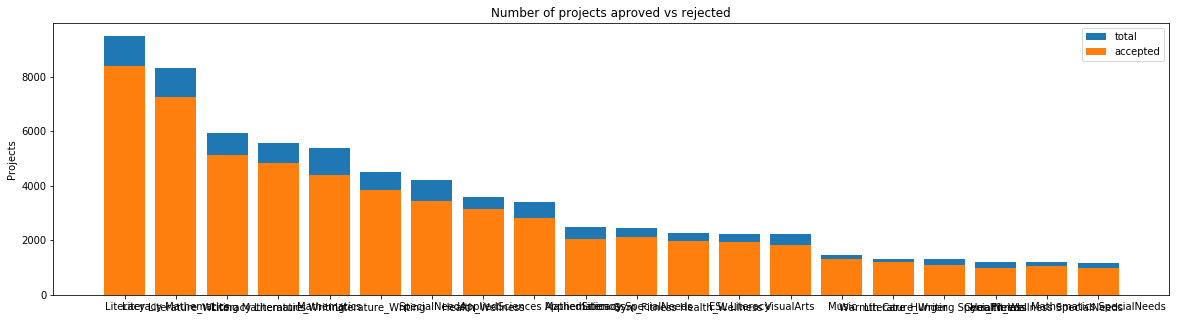

              cleaned_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
               cleaned_subcategories  project_is_approved  total       Avg
400               Warmth Care_Hunger                 1212   1309  0.925898
338  Literature_Writing SpecialNeeds                 1093   1306  0.836907
256                      Gym_Fitness                 1002   1195  0.838494
300     Health_Wellness SpecialNeeds                 1044   1189  0.878049
349         Mathematics SpecialNeeds                  972   1187  0.818871


In [37]:
temp = pd.DataFrame(project_data.groupby('cleaned_subcategories')['project_is_approved'].apply(np.mean)).reset_index()
univariate_barplots(temp, 'cleaned_subcategories', 'project_is_approved', top=20)

In [38]:
my_counter = Counter()
for word in project_data['cleaned_subcategories']:
    my_counter.update(word.split())

In [39]:
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key = lambda kv : kv[1]))
sorted_sub_cat_dict

{'Economics': 269,
 'CommunityService': 441,
 'FinancialLiteracy': 568,
 'ParentInvolvement': 677,
 'Extracurricular': 810,
 'Civics_Government': 815,
 'ForeignLanguages': 890,
 'NutritionEducation': 1355,
 'Warmth': 1388,
 'Care_Hunger': 1388,
 'SocialSciences': 1920,
 'PerformingArts': 1961,
 'CharacterEducation': 2065,
 'TeamSports': 2192,
 'Other': 2372,
 'College_CareerPrep': 2568,
 'Music': 3145,
 'History_Geography': 3171,
 'Health_LifeScience': 4235,
 'EarlyDevelopment': 4254,
 'ESL': 4367,
 'Gym_Fitness': 4509,
 'EnvironmentalScience': 5591,
 'VisualArts': 6278,
 'Health_Wellness': 10234,
 'AppliedSciences': 10816,
 'SpecialNeeds': 13642,
 'Literature_Writing': 22179,
 'Mathematics': 28074,
 'Literacy': 33700}

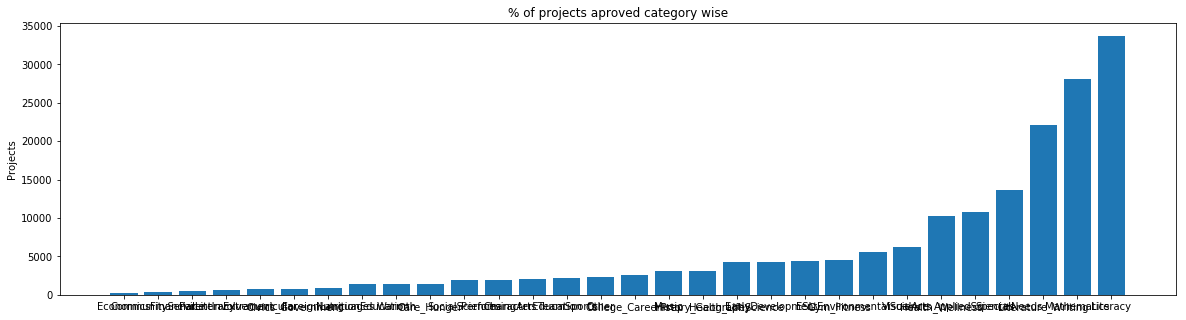

In [40]:
ind = np.arange(len(sub_cat_dict))
plt.figure(figsize=(20,5))
pl = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [41]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


##### Observation:
##### All the subject sub-categories have an approval rating of more than 80%
#### There is a significant difference between the number of projects submitted under each sub-category.

#### 6. Project Title

In [42]:
# https://stackoverflow.com/a/37483537/4084039

word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_count

4     19979
5     19677
3     18691
6     14824
7     10631
2      8733
8      7289
9      5383
10     3968
1        31
11       30
12       11
13        1
Name: project_title, dtype: int64

In [43]:
word_dict = dict(word_count)
word_dict

{4: 19979,
 5: 19677,
 3: 18691,
 6: 14824,
 7: 10631,
 2: 8733,
 8: 7289,
 9: 5383,
 10: 3968,
 1: 31,
 11: 30,
 12: 11,
 13: 1}

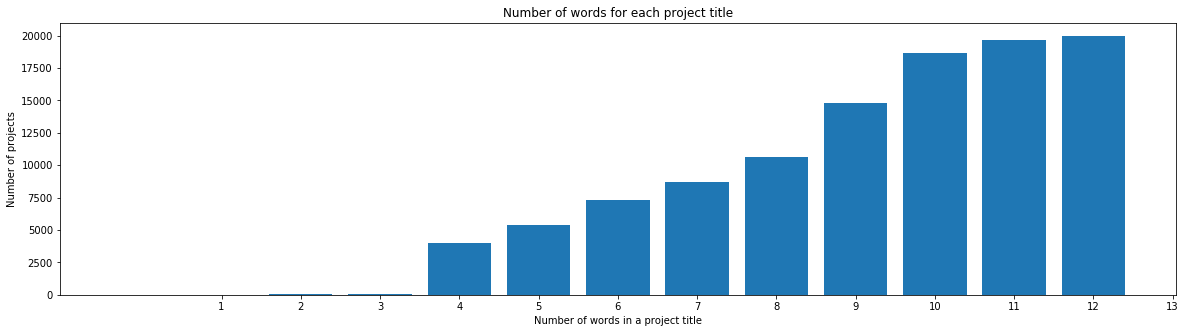

In [44]:
word_dict_sorted = dict(sorted(word_dict.items(), key = lambda kv:kv[1]))

ind = np.arange(len(word_dict_sorted))
plt.figure(figsize=(20,5))
plt.bar(ind, list(word_dict_sorted.values()))

plt.ylabel('Number of projects')
plt.xlabel('Number of words in a project title')
plt.title('Number of words for each project title')
plt.xticks(list(word_dict_sorted.keys()))
plt.show()

In [45]:
word_dict_sorted.values()

dict_values([1, 11, 30, 31, 3968, 5383, 7289, 8733, 10631, 14824, 18691, 19677, 19979])

In [46]:
approved_title_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

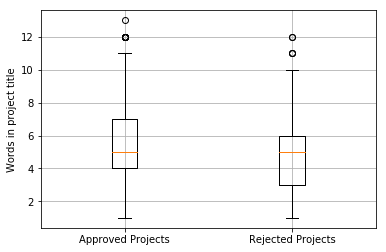

In [47]:
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

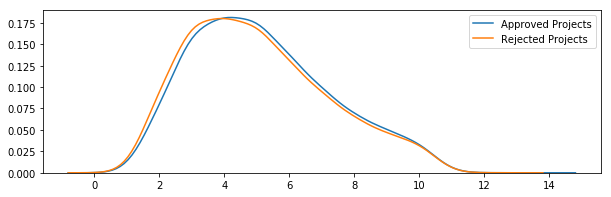

In [48]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count, label='Approved Projects', bw=0.6)
sns.kdeplot(rejected_title_word_count, label='Rejected Projects', bw=0.6)
plt.legend()
plt.show()

##### Observation: The word counts of the titles of both approved and rejected projects have significant amount of overlapping, hence are not linearly seperable.

#### 7. Project Essays

In [49]:
# https://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-dataframe-in-pandas-python
project_data['Essays'] = project_data['project_essay_1'].map(str) +\
                         project_data['project_essay_2'].map(str) +\
                         project_data['project_essay_2'].map(str) +\
                         project_data['project_essay_2'].map(str)

In [50]:
approved_essay_word_count = project_data[project_data['project_is_approved']==1]['Essays'].str.split().apply(len)
approved_essay_word_count = approved_essay_word_count.values

rejected_essay_word_count = project_data[project_data['project_is_approved']==0]['Essays'].str.split().apply(len)
rejected_essay_word_count = rejected_essay_word_count.values

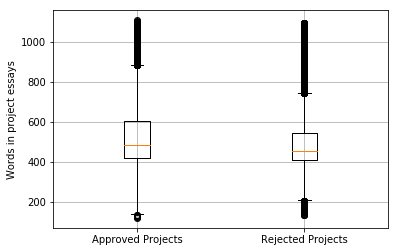

In [51]:
plt.boxplot([approved_essay_word_count, rejected_essay_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.grid()
plt.show()

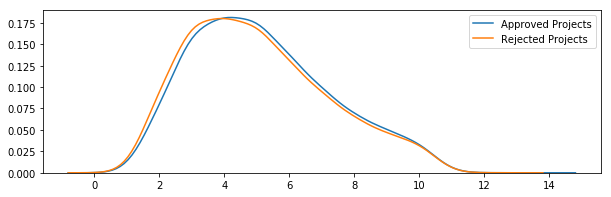

In [52]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count, label='Approved Projects', bw=0.6)
sns.kdeplot(rejected_title_word_count, label='Rejected Projects', bw=0.6)
plt.legend()
plt.show()

##### Observation: The word counts of the titles of both approved and rejected projects have significant amount of overlapping, hence are not linearly seperable. Also they have a large number of outliers.

#### 8. Cost per project

In [53]:
resources_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [54]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step

price_data = resources_data.groupby('id').aggregate({'price':'sum', 'quantity': 'sum'}).reset_index()
price_data.head(3)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21
2  p000003  298.97         4

In [55]:
#https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

project_data = pd.merge(project_data, price_data, on='id', how='left')
project_data.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   
2                                             1                    0   
3                                             4                    1   
4                                             1                    1   

                 clean_categories         cleaned_subcategories  \
0               Literacy_Language                  ESL Literacy   
1    History_Civics Health_Sports  Civics_Government TeamSports   
2                   Health_Sports    Health_Wellness TeamSports   
3  Literacy_Language Math_Science          Literacy Mathematics   
4                    Math_Science                   Mathematics   

                                              Essays   price  quantity  
0  My students are English learners that are work...  154.60        23  
1  Our students arrive to our school eager to lea...  299.00         1  
2  \r\n\"True champions aren't always the ones th...  516.85        22  
3  I work at a unique school filled with both ESL...  232.90         4  
4  Our second grade classroom next year will be m...   67.98         4

In [56]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values
rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

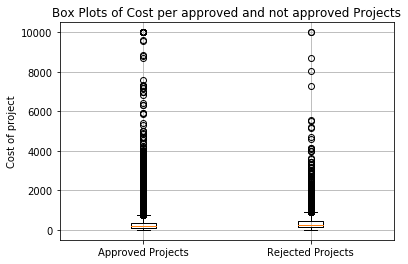

In [57]:
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.ylabel('Cost of project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.grid()
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

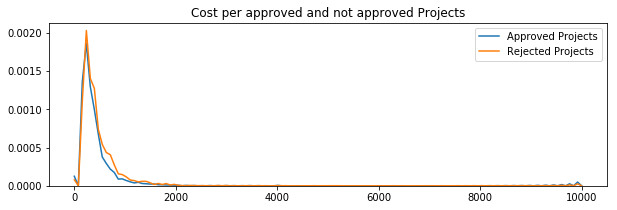

In [58]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_price, label='Approved Projects', bw=0.6)
sns.kdeplot(rejected_price, label='Rejected Projects', bw=0.6)
plt.title('Cost per approved and not approved Projects')
plt.show

In [59]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ('Percentile', 'Cost of projects approved', 'Cost of projects rejected')

for i in range(0,101,5):
    x.add_row([i, np.round(np.percentile(approved_price,i),3), np.round(np.percentile(rejected_price,i),3)])
print(x)

+------------+---------------------------+---------------------------+
| Percentile | Cost of projects approved | Cost of projects rejected |
+------------+---------------------------+---------------------------+
|     0      |            0.66           |            1.97           |
|     5      |           13.59           |            41.9           |
|     10     |           33.88           |           73.67           |
|     15     |            58.0           |           99.109          |
|     20     |           77.38           |           118.56          |
|     25     |           99.95           |          140.892          |
|     30     |           116.68          |           162.23          |
|     35     |          137.232          |          184.014          |
|     40     |           157.0           |          208.632          |
|     45     |          178.265          |          235.106          |
|     50     |           198.99          |          263.145          |
|     

##### Observation:  The average cost of approved projects is less than that of rejected/unapproved projects.

#### 9. Teacher number of previously posted projects

In [60]:
approved_projects_count = project_data[project_data['project_is_approved']==1]['teacher_number_of_previously_posted_projects'].values
rejected_projects_count = project_data[project_data['project_is_approved']==0]['teacher_number_of_previously_posted_projects'].values

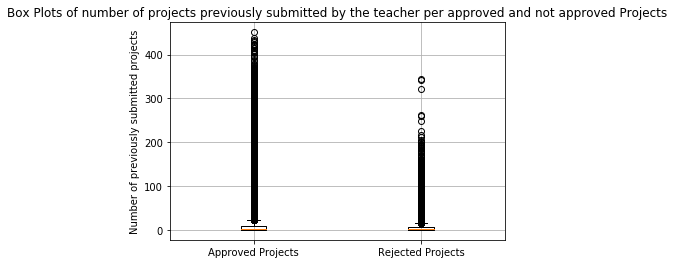

In [61]:
plt.boxplot([approved_projects_count, rejected_projects_count])
plt.title('Box Plots of number of projects previously submitted by the teacher per approved and not approved Projects')
plt.ylabel('Number of previously submitted projects')
plt.xticks([1,2],('Approved Projects', 'Rejected Projects'))
plt.grid()
plt.show()

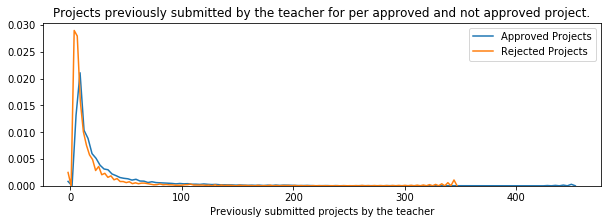

In [62]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_projects_count, label='Approved Projects', bw=0.6)
sns.kdeplot(rejected_projects_count, label='Rejected Projects', bw=0.6)
plt.title('Projects previously submitted by the teacher for per approved and not approved project.')
plt.xlabel('Previously submitted projects by the teacher')
plt.show()

##### Observation: The data for approved and rejected projects has significant amount of overlapping, hence its difficult to linearly seperate them using this feature.

#### 10. Project resource summary

In [63]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories         cleaned_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                              Essays  price  quantity  
0  My students are English learners that are work...  154.6        23  
1  Our students arrive to our school eager to lea...  299.0         1

In [64]:
approved_projects_count = project_data[project_data['project_is_approved']==1]['project_resource_summary'].str.split().apply(len)
rejected_projects_count = project_data[project_data['project_is_approved']==1]['project_resource_summary'].str.split().apply(len)

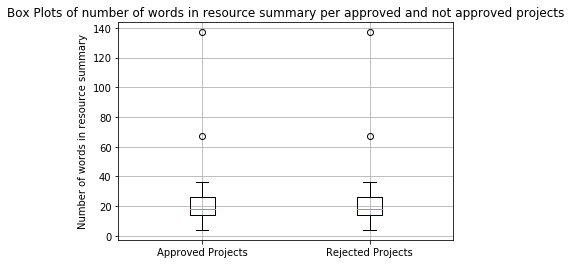

In [65]:
plt.boxplot([approved_projects_count, rejected_projects_count])
plt.title('Box Plots of number of words in resource summary per approved and not approved projects')
plt.ylabel('Number of words in resource summary')
plt.xticks([1,2],('Approved Projects', 'Rejected Projects'))
plt.grid()
plt.show()

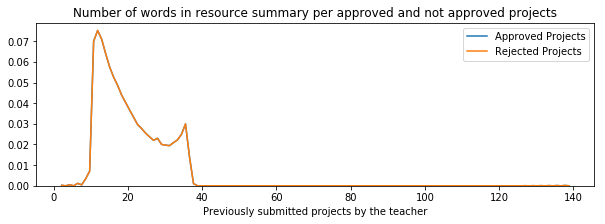

In [66]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_projects_count, label='Approved Projects', bw=0.6)
sns.kdeplot(rejected_projects_count, label='Rejected Projects', bw=0.6)
plt.title('Number of words in resource summary per approved and not approved projects')
plt.xlabel('Previously submitted projects by the teacher')
plt.show()

##### Observation: The data for approved and rejected projects are completely  overlapping, hence its impossible to linearly seperate them using this feature.

In [67]:
#https://stackoverflow.com/questions/19859282/check-if-a-string-contains-a-number
def number_check(input_string):
    if(any(char.isdigit() for char in input_string)):
        return 1
    return 0

In [68]:
resource_summary = project_data['project_resource_summary']
resource_summary_contains_number = resource_summary.map(number_check)
project_data['resource_summary_contains_number'] = resource_summary_contains_number
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  \
0  \"The limits of your language are the limits o...   
1  The projector we need for our school is very c...   

                 ...                project_essay_4  \
0                ...                            NaN   
1                ...                            NaN   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            0                    0   
1                                            7                    1   

               clean_categories         cleaned_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                              Essays  price  quantity  \
0  My students are English learners that are work...  154.6        23   
1  Our students arrive to our school eager to lea...  299.0         1   

   resource_summary_contains_number  
0                                 0  
1                                 0  

[2 rows x 21 columns]

In [69]:
number_projects_counts = project_data[project_data['project_is_approved']==1]['project_is_approved']
print('Total number of projects approved:',len(number_projects_counts))

Total number of projects approved: 92706


In [70]:
number_projects_counts_with_number = project_data[project_data['resource_summary_contains_number']==1]['project_is_approved']
print('Number of projects that had a number in their project resource summary:',len(number_projects_counts_with_number))

Number of projects that had a number in their project resource summary: 15756


In [71]:
number_projects_counts_with_number_approved = project_data[(project_data['project_is_approved']==1) & (project_data['resource_summary_contains_number']==1)]
print('Number of projects that had a number in their project resource summary and got approved:',len(number_projects_counts_with_number))

Number of projects that had a number in their project resource summary and got approved: 15756


##### Observation: As we can see all the projects that had presence of the numerical digits in their project summaries got approved. Therefore we can conclude that it is highly critical to have numerical digits in the project summary for the project to get approved.

## 3. Text Preprocessing

#### 1. Essays

In [72]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  \
0  \"The limits of your language are the limits o...   
1  The projector we need for our school is very c...   

                 ...                project_essay_4  \
0                ...                            NaN   
1                ...                            NaN   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            0                    0   
1                                            7                    1   

               clean_categories         cleaned_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                              Essays  price  quantity  \
0  My students are English learners that are work...  154.6        23   
1  Our students arrive to our school eager to lea...  299.0         1   

   resource_summary_contains_number  
0                                 0  
1                                 0  

[2 rows x 21 columns]

In [73]:
project_data['Essays'][2000]

"Describing my students isn't an easy task.  Many would say that they are inspirational, creative, and hard-working.  They are all unique - unique in their interests, their learning, their abilities, and so much more.  What they all have in common is their desire to learn each day, despite difficulties that they encounter.  \\r\\nOur classroom is amazing - because we understand that everyone learns at their own pace.  As the teacher, I pride myself in making sure my students are always engaged, motivated, and inspired to create their own learning! \\r\\nThis project is to help my students choose seating that is more appropriate for them, developmentally.  Many students tire of sitting in chairs during lessons, and having different seats available helps to keep them engaged and learning.\\r\\nFlexible seating is important in our classroom, as many of our students struggle with attention, focus, and engagement.  We currently have stability balls for seating, as well as regular chairs, bu

In [74]:
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [75]:
# https://gist.github.com/sebleier/554280

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [76]:
# https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string/5843547#5843547

from bs4 import BeautifulSoup
from tqdm import tqdm

preprocessed_essays = [];
for sentence in tqdm(project_data['Essays'].values):
    sentence = re.sub(r"http\S+", '',sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", '', sentence).strip()
    sentence = re.sub('[^A-Za-z0-9]+',' ', sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sentence)

100%|██████████| 109248/109248 [02:32<00:00, 717.90it/s]


In [77]:
preprocessed_essays[2000]

'describing students not easy task many would say inspirational creative hard working unique unique interests learning abilities much common desire learn day despite difficulties encounter r nour classroom amazing understand everyone learns pace teacher pride making sure students always engaged motivated inspired create learning r nthis project help students choose seating appropriate developmentally many students tire sitting chairs lessons different seats available helps keep engaged learning r nflexible seating important classroom many students struggle attention focus engagement currently stability balls seating well regular chairs stools help students trouble balance find difficult sit stability ball long period time excited try stools part engaging classroom community project help students choose seating appropriate developmentally many students tire sitting chairs lessons different seats available helps keep engaged learning r nflexible seating important classroom many students 

#### 2. Title

In [78]:
len(project_data['project_title'])

109248

In [79]:
preprocessed_titles = [];
for sentence in tqdm(project_data['project_title'].values):
    sentence = re.sub(r"http\S+", '',sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", '', sentence).strip()
    sentence = re.sub('[^A-Za-z0-9]+',' ', sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_titles.append(sentence)

100%|██████████| 109248/109248 [00:47<00:00, 2302.57it/s]


In [80]:
preprocessed_titles[2000]
len(preprocessed_titles)

109248

##### 3. Project Resource Summary

In [81]:
project_data['project_resource_summary'][2000]

'My students need active stools to help them focus during lessons and class work.'

In [82]:
preprocessed_resource_summary = [];
for sentence in tqdm(project_data['project_title'].values):
    sentence = re.sub(r"http\S+", '',sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", '', sentence).strip()
    sentence = re.sub('[^A-Za-z0-9]+',' ', sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_resource_summary.append(sentence)

100%|██████████| 109248/109248 [00:34<00:00, 3208.57it/s]


In [83]:
len(preprocessed_resource_summary)

109248

## 4. Preparing data for models

In [84]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'cleaned_subcategories', 'Essays', 'price',
       'quantity', 'resource_summary_contains_number'],
      dtype='object')

We are going to consider only the following features :-

1. Categorical Data
   - teacher_prefix
   - school_state
   - project_grade_category
   - clean_categories
   - cleaned_subcategories
   
   
2. Text Data
   - project_title
   - Essays
   - project_resources
   
   
3. Numerical Data
   - price
   - quantity
   - teacher_number_of_previously_posted_projects
   - resource_summary_contains_number

### 4.1 Vectorizing Categorical data

##### 1. Cleaned Categories

In [85]:
vectorizer = CountVectorizer()
categories_one_hot = vectorizer.fit_transform(project_data['clean_categories'].values)
categories_one_hot.shape

(109248, 9)

##### 2. Cleaned Subcategories

In [86]:
subcategories_one_hot = vectorizer.fit_transform(project_data['cleaned_subcategories'].values)
subcategories_one_hot.shape

(109248, 30)

##### 3. Project Grade Category

In [87]:
my_counter = Counter()
for word in project_data['project_grade_category'].values:
    my_counter.update(word.split())
project_grade_cat_dict = dict(my_counter)

In [88]:
# https://stackoverflow.com/questions/4406501/change-the-name-of-a-key-in-dictionary

project_grade_cat_dict['Grades PreK-2'] = project_grade_cat_dict['PreK-2']
project_grade_cat_dict['Grades 6-8'] = project_grade_cat_dict['6-8']
project_grade_cat_dict['Grades 3-5'] = project_grade_cat_dict['3-5']
project_grade_cat_dict['Grades 9-12'] = project_grade_cat_dict['9-12']
del project_grade_cat_dict['Grades']
del project_grade_cat_dict['PreK-2']
del project_grade_cat_dict['6-8']
del project_grade_cat_dict['3-5']
del project_grade_cat_dict['9-12']
project_grade_cat_dict_sort = dict(sorted(project_grade_cat_dict.items(), key = lambda kv: kv[1]))

In [89]:
project_grade_vectorizer = CountVectorizer(vocabulary=list(project_grade_cat_dict_sort.keys()), lowercase=False, binary=True)
project_grade_categories_one_hot = project_grade_vectorizer.fit_transform(project_data['project_grade_category'].values)
project_grade_categories_one_hot.shape

(109248, 4)

##### 4. Teacher Prefix

In [90]:
my_counter = Counter()
for word in project_data['teacher_prefix'].values:
    my_counter.update(str(word).split())
teacher_prefix_dict = dict(my_counter)
teacher_prefix_dict_sort = dict(sorted(teacher_prefix_dict.items(), key = lambda kv: kv[1]))

In [91]:
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document

teacher_prefix_vectorizer = CountVectorizer(vocabulary=list(teacher_prefix_dict_sort.keys()), lowercase=False, binary=True)
teacher_prefix_one_hot = project_grade_vectorizer.fit_transform(project_data['teacher_prefix'].values.astype('U'))
teacher_prefix_one_hot.shape

(109248, 4)

##### 5. School State

In [92]:
my_counter = Counter()
for word in project_data['school_state'].values:
    my_counter.update(word.split())
school_state_dict = dict(my_counter)
school_state_dict_sort = dict(sorted(school_state_dict.items(), key = lambda kv: kv[1]))

In [93]:
school_state_vectorizer = CountVectorizer(vocabulary=list(school_state_dict_sort.keys()), lowercase=False, binary=True)
school_state_one_hot = school_state_vectorizer.fit_transform(project_data['school_state'].values.astype('U'))
school_state_one_hot.shape

(109248, 51)

### 4.2 Vectorizing Text Data

##### 1. Project Essays

- Bag of Words (Bow)

In [94]:
vectorizor = CountVectorizer(min_df = 10)
essays_bow = vectorizer.fit_transform(preprocessed_essays)
essays_bow.shape

(109248, 58373)

- TFIDF Vectorizer

In [95]:
vectorizer = TfidfVectorizer(min_df = 10)
essays_tfidf = vectorizer.fit_transform(preprocessed_essays)
essays_tfidf.shape

(109248, 16722)

- Average Word2Vector (Avg W2V)

In [96]:
# Taking referrence from Amazon Fine Food Reviews

essays_sentences = []
for sentence in preprocessed_essays:
    essays_sentences.append(sentence)

In [97]:
essays_w2v_model = Word2Vec(essays_sentences, min_count=5, size=300, workers=5) 
essays_w2v_words = essays_w2v_model.wv.vocab
essays_w2v_words

{'s': <gensim.models.keyedvectors.Vocab at 0x1a3bce7d30>,
 't': <gensim.models.keyedvectors.Vocab at 0x1a37d15128>,
 'u': <gensim.models.keyedvectors.Vocab at 0x1a37d15ba8>,
 'd': <gensim.models.keyedvectors.Vocab at 0x1a37c737b8>,
 'e': <gensim.models.keyedvectors.Vocab at 0x1a37c739b0>,
 'n': <gensim.models.keyedvectors.Vocab at 0x1a37c73b00>,
 ' ': <gensim.models.keyedvectors.Vocab at 0x1a37c73e48>,
 'g': <gensim.models.keyedvectors.Vocab at 0x1a37c73588>,
 'l': <gensim.models.keyedvectors.Vocab at 0x1a37c73198>,
 'i': <gensim.models.keyedvectors.Vocab at 0x1a37c73828>,
 'h': <gensim.models.keyedvectors.Vocab at 0x1a37c73748>,
 'a': <gensim.models.keyedvectors.Vocab at 0x1a37c735f8>,
 'r': <gensim.models.keyedvectors.Vocab at 0x1a37c734e0>,
 'w': <gensim.models.keyedvectors.Vocab at 0x1a37c730b8>,
 'o': <gensim.models.keyedvectors.Vocab at 0x1a37c73b70>,
 'k': <gensim.models.keyedvectors.Vocab at 0x1a37c73d30>,
 'c': <gensim.models.keyedvectors.Vocab at 0x1a37c73940>,
 'm': <gensim.

In [98]:
essays_w2v_vectors = []

for sent in essays_sentences:
    sent_vec= np.zeros(300)
    count=0
    for word in sent:
        if word in essays_w2v_words:
            vec = essays_w2v_model.wv[word]
            sent_vec += vec
            count += 1
    if count != 0:
        sent_vec /= count
        essays_w2v_vectors.append(sent_vec)
# sentence_vectors[0]
print(len(essays_w2v_vectors))
print(len(essays_w2v_vectors[0]))

109248
300


- TFIDF weighted W2V

In [99]:
# Taking referrence from Amazon Fine Food Reviews

model = TfidfVectorizer()
model.fit(preprocessed_essays)
essays_tfidf_dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [100]:
essays_tfidf_words = set(model.get_feature_names())
essays_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in essays_w2v_words) and (word in essays_tfidf_words):
            vec = w2v_model.wv[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = essays_tfidf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    essays_tfidf_w2v_vectors.append(vector)

print(len(essays_tfidf_w2v_vectors))
print(len(essays_tfidf_w2v_vectors[0]))

100%|██████████| 109248/109248 [00:07<00:00, 14753.03it/s]

109248
300


##### 2. Project Title

- Bag of Words

In [101]:
vectorizor = CountVectorizer(min_df = 10)
titles_bow = vectorizer.fit_transform(preprocessed_titles)
titles_bow.shape

(109248, 3192)

- TFIDF Vectorizer

In [102]:
vectorizer = TfidfVectorizer(min_df = 10)
titles_tfidf = vectorizer.fit_transform(preprocessed_titles)
titles_tfidf.shape

(109248, 3192)

- Average Word2Vector

In [103]:
# Taking referrence from Amazon Fine Food Reviews

titles_sentences = []
for sentence in preprocessed_titles:
    titles_sentences.append(sentence)

In [104]:
titles_w2v_model = Word2Vec(titles_sentences, min_count=1, size=300, workers=5) 
titles_w2v_words = titles_w2v_model.wv.vocab

In [105]:
titles_w2v_vectors = []

for sent in titles_sentences:
    sent_vec= np.zeros(300)
    count=0
    for word in sent:
        if word in titles_w2v_words:
            vec = titles_w2v_model.wv[word]
            sent_vec += vec
            count += 1
    if count != 0:
        sent_vec /= count
        titles_w2v_vectors.append(sent_vec)
# sentence_vectors[0]
print(len(titles_w2v_vectors))
print(len(titles_w2v_vectors[0]))

109191
300


- TFIDF weighted W2V

In [106]:
# Taking referrence from Amazon Fine Food Reviews

model = TfidfVectorizer()
model.fit(preprocessed_titles)
titles_tfidf_dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [107]:
titles_tfidf_words = set(model.get_feature_names())
titles_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in titles_w2v_words) and (word in titles_tfidf_words):
            vec = titles_w2v_model.wv[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = titles_tfidf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    titles_tfidf_w2v_vectors.append(vector)

print(len(titles_tfidf_w2v_vectors))
print(len(titles_tfidf_w2v_vectors[0]))

100%|██████████| 109248/109248 [00:00<00:00, 121400.13it/s]


109248
300


##### 3. Project Resource Summary

- Bag of Words (Bow)

In [108]:
vectorizor = CountVectorizer(min_df = 10)
resource_summary_bow = vectorizer.fit_transform(preprocessed_resource_summary)
resource_summary_bow.shape

(109248, 3192)

- TFIDF Vectorizer

In [109]:
vectorizer = TfidfVectorizer(min_df = 10)
resource_summary_tfidf = vectorizer.fit_transform(preprocessed_titles)
resource_summary_tfidf.shape

(109248, 3192)

- Average Word2Vector (Avg W2V)

In [110]:
# Taking referrence from Amazon Fine Food Reviews

resource_summary_sentences = []
for sentence in preprocessed_resource_summary:
    resource_summary_sentences.append(sentence)

In [111]:
resource_summary_w2v_model = Word2Vec(resource_summary_sentences, min_count=5, size=300, workers=5) 
resource_summary_w2v_words = resource_summary_w2v_model.wv.vocab

In [112]:
resource_summary_w2v_vectors = []

for sent in resource_summary_sentences:
    sent_vec= np.zeros(300)
    count=0
    for word in sent:
        if word in resource_summary_w2v_words:
            vec = resource_summary_w2v_model.wv[word]
            sent_vec += vec
            count += 1
    if count != 0:
        sent_vec /= count
        resource_summary_w2v_vectors.append(sent_vec)
# sentence_vectors[0]
print(len(resource_summary_w2v_vectors))
print(len(resource_summary_w2v_vectors[0]))

109191
300


- TFIDF weighted W2V

In [113]:
# Taking referrence from Amazon Fine Food Reviews

model = TfidfVectorizer()
model.fit(preprocessed_resource_summary)
resource_summary_tfidf_dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [114]:
resource_summary_tfidf_words = set(model.get_feature_names())
resource_summary_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_resource_summary): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in resource_summary_w2v_words) and (word in resource_summary_tfidf_words):
            vec = resource_summary_w2v_model.wv[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = resource_summary_tfidf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    resource_summary_tfidf_w2v_vectors.append(vector)

print(len(resource_summary_tfidf_w2v_vectors))
print(len(resource_summary_tfidf_w2v_vectors[0]))

100%|██████████| 109248/109248 [00:00<00:00, 118830.75it/s]

109248
300


### 4.3 Standardizing Numerical Data

##### 1. Price

In [115]:
type(project_data['price'].values)

numpy.ndarray

In [116]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

price_scalar = StandardScaler()
price_standardized = price_scalar.fit_transform(project_data['price'].values.reshape(-1,1))
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

Mean : 298.1193425966608, Standard deviation : 367.49634838483496


In [117]:
price_standardized

array([[-0.3905327 ],
       [ 0.00239637],
       [ 0.59519138],
       ...,
       [-0.15825829],
       [-0.61243967],
       [-0.51216657]])

##### 2. Resource summary contains number

In [118]:
type(project_data['teacher_number_of_previously_posted_projects'].values)

numpy.ndarray

In [120]:
from sklearn.preprocessing import StandardScaler
teacher_number_of_previously_posted_projects_scalar = StandardScaler()
teacher_number_of_previously_posted_projects_standardized = teacher_number_of_previously_posted_projects_scalar.fit_transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



In [121]:
teacher_number_of_previously_posted_projects_standardized

array([[-0.40152481],
       [-0.14951799],
       [-0.36552384],
       ...,
       [-0.29352189],
       [-0.40152481],
       [-0.40152481]])

## 5. Apply TSNE

#### 1. Categorical, Numerical features + project_title(BOW)

In [162]:
print(categories_one_hot.shape)
print(subcategories_one_hot.shape)
print(project_grade_categories_one_hot.shape)
print(teacher_prefix_one_hot.shape)
print(school_state_one_hot.shape)

print(price_standardized.shape)
print(teacher_number_of_previously_posted_projects_standardized.shape)

(109248, 9)
(109248, 30)
(109248, 4)
(109248, 4)
(109248, 51)
(109248, 1)
(109248, 1)


In [163]:
print(essays_bow.shape)
print(titles_bow.shape)

(109248, 58373)
(109248, 3192)


In [164]:
# https://stackoverflow.com/questions/19710602/concatenate-sparse-matrices-in-python-using-scipy-numpy/19710648#19710648

from scipy.sparse import hstack

data_sample = hstack((categories_one_hot[0:5000,:], subcategories_one_hot[0:5000,:], project_grade_categories_one_hot[0:5000,:],
            teacher_prefix_one_hot[0:5000,:], school_state_one_hot[0:5000,:], titles_bow[0:5000,:], price_standardized[0:5000,:], 
            teacher_number_of_previously_posted_projects_standardized[0:5000,:]))
data_sample.shape

(5000, 3292)

In [165]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

In [166]:
final = csr_matrix.todense(data_sample)
data_sample = StandardScaler().fit_transform(final)
data_sample.shape

(5000, 3292)

In [167]:
label_data = project_data['project_is_approved'][0:5000]
label_data

0       0
1       1
2       0
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      0
13      1
14      0
15      1
16      1
17      1
18      1
19      1
20      1
21      1
22      0
23      1
24      1
25      0
26      1
27      1
28      0
29      1
       ..
4970    0
4971    0
4972    1
4973    1
4974    1
4975    1
4976    0
4977    1
4978    0
4979    1
4980    1
4981    1
4982    1
4983    1
4984    1
4985    1
4986    1
4987    1
4988    1
4989    1
4990    1
4991    1
4992    1
4993    1
4994    1
4995    1
4996    1
4997    0
4998    1
4999    1
Name: project_is_approved, Length: 5000, dtype: int64

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



Text(0.5, 1.0, "'TSNE with `BOW` encoding of `project_title` feature'")

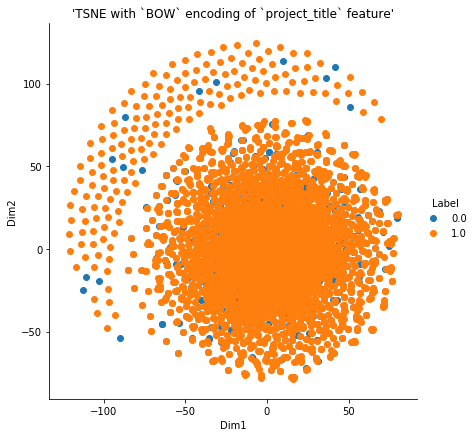

In [169]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0, perplexity=50)
tsne_data = tsne_model.fit_transform(data_sample)

tsne_data = np.vstack((tsne_data.T, label_data)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','Label'))

sns.FacetGrid(tsne_df, hue='Label', size=6).map(plt.scatter, 'Dim1','Dim2').add_legend()
plt.title("TSNE with `BOW` encoding of `project_title` feature")

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



Text(0.5, 1.0, 'TSNE with `BOW` encoding of `project_title` feature')

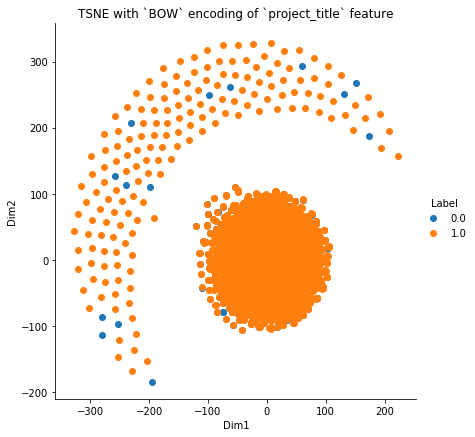

In [171]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)
tsne_data = tsne_model.fit_transform(data_sample)

tsne_data = np.vstack((tsne_data.T, label_data)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','Label'))

sns.FacetGrid(tsne_df, hue='Label', size=6).map(plt.scatter, 'Dim1','Dim2').add_legend()
plt.title("TSNE with `BOW` encoding of `project_title` feature")

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



Text(0.5, 1.0, 'TSNE with `BOW` encoding of `project_title` feature')

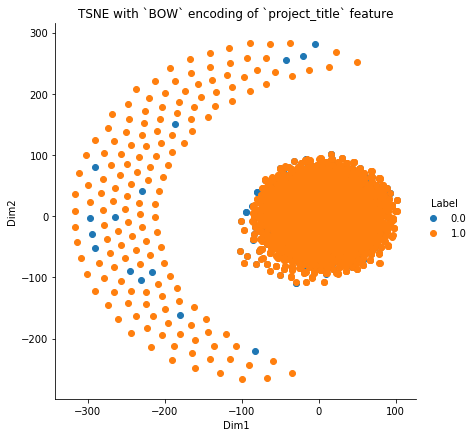

In [172]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=70, n_iter=5000)
tsne_data = tsne_model.fit_transform(data_sample)

tsne_data = np.vstack((tsne_data.T, label_data)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','Label'))

sns.FacetGrid(tsne_df, hue='Label', size=6).map(plt.scatter, 'Dim1','Dim2').add_legend()
plt.title("TSNE with `BOW` encoding of `project_title` feature")

##### Conclusion: After taking multiple values of perplexity and n_iter (number of iterations), we can say that the values 70 and 5000 respectively gives us a stable result.

#### 2. Categorical, Numerical features + project_title(TFIDF)

In [173]:
from scipy.sparse import hstack

data_sample = hstack((categories_one_hot[0:5000,:], subcategories_one_hot[0:5000,:], project_grade_categories_one_hot[0:5000,:],
            teacher_prefix_one_hot[0:5000,:], school_state_one_hot[0:5000,:], titles_tfidf[0:5000,:], price_standardized[0:5000,:], 
            teacher_number_of_previously_posted_projects_standardized[0:5000,:]))
data_sample.shape

(5000, 3292)

In [174]:
final = csr_matrix.todense(data_sample)
data_sample = StandardScaler().fit_transform(final)
data_sample.shape

(5000, 3292)

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



Text(0.5, 1.0, 'TSNE with `TFIDF` encoding of `project_title` feature')

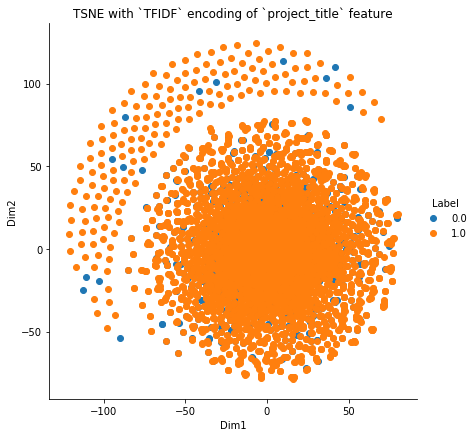

In [175]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=50)
tsne_data = tsne_model.fit_transform(data_sample)

tsne_data = np.vstack((tsne_data.T, label_data)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','Label'))

sns.FacetGrid(tsne_df, hue='Label', size=6).map(plt.scatter, 'Dim1','Dim2').add_legend()
plt.title("TSNE with `TFIDF` encoding of `project_title` feature")

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



Text(0.5, 1.0, 'TSNE with `TFIDF` encoding of `project_title` feature')

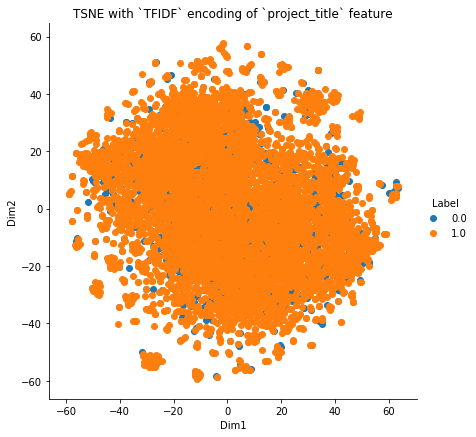

In [179]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=70, n_iter=5000)
tsne_data = tsne_model.fit_transform(data_sample)

tsne_data = np.vstack((tsne_data.T, label_data)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','Label'))

sns.FacetGrid(tsne_df, hue='Label', size=6).map(plt.scatter, 'Dim1','Dim2').add_legend()
plt.title("TSNE with `TFIDF` encoding of `project_title` feature")

#### 3. Categorical, Numerical features + project_title(AVG W2V)

In [180]:
standardized_tiles_w2v = StandardScaler().fit_transform(titles_w2v_vectors)
standardized_tiles_w2v.shape

(109191, 300)

In [181]:
from scipy.sparse import hstack

data_sample = hstack((categories_one_hot[0:5000,:], subcategories_one_hot[0:5000,:], project_grade_categories_one_hot[0:5000,:],
            teacher_prefix_one_hot[0:5000,:], school_state_one_hot[0:5000,:], standardized_tiles_w2v[0:5000,:], price_standardized[0:5000,:], 
            teacher_number_of_previously_posted_projects_standardized[0:5000,:]))
data_sample.shape

(5000, 400)

In [182]:
final = csr_matrix.todense(data_sample)
data_sample = StandardScaler().fit_transform(final)
data_sample.shape

(5000, 400)

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



Text(0.5, 1.0, 'TSNE with `AVG W2V` encoding of `project_title` feature')

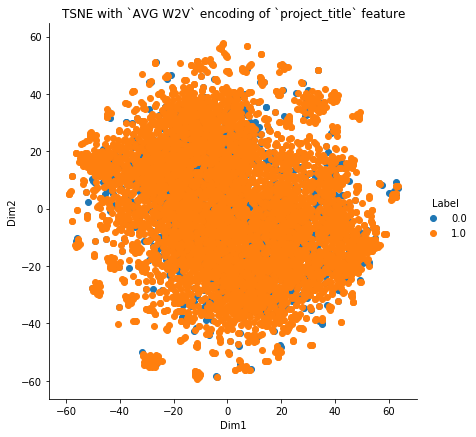

In [183]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=70, n_iter=5000)
tsne_data = tsne_model.fit_transform(data_sample)

tsne_data = np.vstack((tsne_data.T, label_data)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','Label'))

sns.FacetGrid(tsne_df, hue='Label', size=6).map(plt.scatter, 'Dim1','Dim2').add_legend()
plt.title('TSNE with `AVG W2V` encoding of `project_title` feature')

#### 4. Categorical, Numerical features + project_title(TFIDF W2V)

In [184]:
standardized_tiles_tfidf_w2v = StandardScaler().fit_transform(titles_tfidf_w2v_vectors)
standardized_tiles_tfidf_w2v.shape

(109248, 300)

In [185]:
from scipy.sparse import hstack

data_sample = hstack((categories_one_hot[0:5000,:], subcategories_one_hot[0:5000,:], project_grade_categories_one_hot[0:5000,:],
            teacher_prefix_one_hot[0:5000,:], school_state_one_hot[0:5000,:], standardized_tiles_tfidf_w2v[0:5000,:], price_standardized[0:5000,:], 
            teacher_number_of_previously_posted_projects_standardized[0:5000,:]))
data_sample.shape

(5000, 400)

In [186]:
final = csr_matrix.todense(data_sample)
data_sample = StandardScaler().fit_transform(final)
data_sample.shape

(5000, 400)

Text(0.5, 1.0, 'TSNE with `TFIDF W2V` encoding of `project_title` feature')

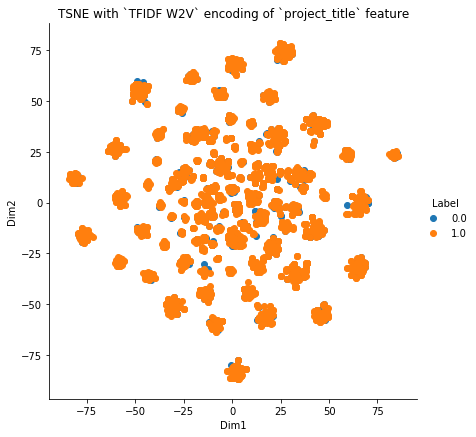

In [189]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=70, n_iter=5000)
tsne_data = tsne_model.fit_transform(data_sample)

tsne_data = np.vstack((tsne_data.T, label_data)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','Label'))

sns.FacetGrid(tsne_df, hue='Label', height=6).map(plt.scatter, 'Dim1','Dim2').add_legend()
plt.title('TSNE with `TFIDF W2V` encoding of `project_title` feature')

#### 5. Concatenating all the above features

In [191]:
from scipy.sparse import hstack

data_sample = hstack((categories_one_hot[0:5000,:], subcategories_one_hot[0:5000,:], project_grade_categories_one_hot[0:5000,:],
            teacher_prefix_one_hot[0:5000,:], school_state_one_hot[0:5000,:], standardized_tiles_tfidf_w2v[0:5000,:],
                       standardized_tiles_w2v[0:5000,:],
                      titles_tfidf[0:5000,:],
                      titles_bow[0:5000,:],
                      price_standardized[0:5000,:], 
            teacher_number_of_previously_posted_projects_standardized[0:5000,:]))
data_sample.shape

(5000, 7084)

In [192]:
final = csr_matrix.todense(data_sample)
data_sample = StandardScaler().fit_transform(final)
data_sample.shape

(5000, 7084)

Text(0.5, 1.0, 'TSNE with All the encodings of `project_title` feature')

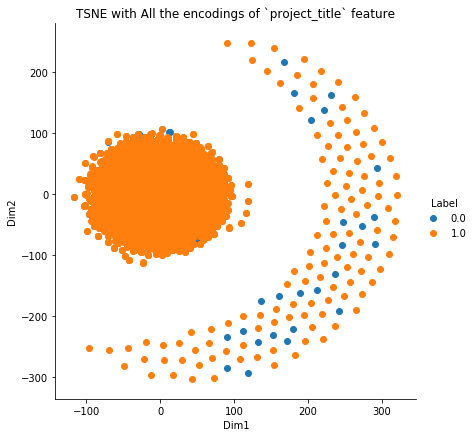

In [193]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=70, n_iter=5000)
tsne_data = tsne_model.fit_transform(data_sample)

tsne_data = np.vstack((tsne_data.T, label_data)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','Label'))

sns.FacetGrid(tsne_df, hue='Label', height=6).map(plt.scatter, 'Dim1','Dim2').add_legend()
plt.title('TSNE with All the encodings of `project_title` feature')

##### Conclusion: After assessing all five T-SNE plots with different encodings of 'project_title' we can conclude that none of the plots can be used to linearly seperate the approved and rejected projects. Hence, they cannot be straightaway used for classification purpose. Although, by just observing these graphs most of the titles of the projects that got approved were similar (In case of 'Avg W2V', we can also say semantically similar).

## 6. Summary

#### In the above performed analysis, the following observations made:
- The data set in hand is highly imbalanced. Around 85% projects that were submitted got approved.
- The univariate analysis performed on the various features of both train.csv and resources.csv give us little insight on the data, but none of them was helpful for classification purpose.
- One important observation made during the univariate analysis was that all the projects for for which resource summaries had numerical data got approved. Hence, it can be said that it is critical to have some kind of numerical data in the summary of the resource required for a project.
- While performing the T-SNE on various encodings of project title, we observed that none of the plots would serve our purpose of classification, but their visualisation helped us observe that most of the approved projects had similar titles, also semantically similar in some cases.